In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import sqlalchemy as db

In [2]:
widths = (8,7,4,13,43)
header_pd = pd.read_fwf('Labeled_data.txt', widths = widths,skiprows=7, nrows=27)
labeled_data = pd.read_csv('Labeled_data.txt', header=None, delim_whitespace=True, skiprows=37) # extract data
labeled_data.columns = header_pd.iloc[:,3]
labeled_data.head()

-------------,ID,SourceID,RAdeg,DEdeg,Per,R21,phi21,T0,gmag,rmag,...,phi21_r,R2_g,R2_r,Amp_g,Amp_r,log(FAP_g),log(FAP_r),Type,Dmin_g,Dmin_r
0,ZTFJ000000.14+721413.7,2,0.00061,72.23716,0.299150,0.263,6.308,58388.255579,19.613,18.804,...,6.308,0.624,0.873,0.540,0.438,-13.490,-27.331,EW,0.190,0.078
1,ZTFJ000000.19+320847.2,3,0.00080,32.14645,0.287059,0.010,8.024,58280.478081,15.311,14.610,...,8.024,0.940,0.977,0.219,0.197,-7.506,-10.079,EW,0.020,0.017
2,ZTFJ000000.26+311206.3,4,0.00109,31.20176,0.362217,0.132,6.281,58283.461994,16.350,15.844,...,6.281,0.951,0.960,0.233,0.226,-7.830,-9.245,EW,0.013,0.020
3,ZTFJ000000.30+711634.1,5,0.00125,71.27616,0.268515,0.160,5.236,58657.423517,19.144,17.875,...,5.236,0.363,0.623,0.173,0.154,-9.865,-22.037,EW,0.000,0.005
4,ZTFJ000000.30+233400.5,6,0.00125,23.56682,0.269874,0.193,6.302,58437.268664,17.890,16.944,...,6.302,0.910,0.976,0.373,0.352,-7.075,-8.819,EW,0.098,0.034


In [3]:
label = labeled_data.Type.unique()
label = np.delete(label, np.where(label == 'CEPII')) # CEPII has very few example so we ignore it
print(label)

['EW' 'BYDra' 'SR' 'RSCVN' 'RR' 'DSCT' 'EA' 'Mira' 'RRc' 'CEP']


In [ ]:
RA = []
Dec = []
SourceID = []
g_mean = []
g_wmean = [] # weighted mean
g_MAD = []
g_IQR = []
g_f60 = []
g_f70 = []
g_f80 = []
g_f90 = []
g_skew = []
g_kurtosis = []
g_welsh_K = []
g_welsh_J = []

r_mean = []
r_wmean = [] # weighted mean
r_MAD = []
r_IQR = []
r_f60 = []
r_f70 = []
r_f80 = []
r_f90 = []
r_skew = []
r_kurtosis = []
r_welsh_K = []
r_welsh_J = []

In [ ]:
def weighted_mean(mag,mag_err):
    mag2 = (mag_err*mag_err) # mag err square
    mag2_inv = 1/mag2.values; # take inverse of the values
    w = pd.Series(mag2_inv) # covert it back to s series
    sw = w.sum() # sum of weights
    wmag = mag*w # multiply magnitude with weights
    wmean = wmag.sum()/sw # weighted mean
    return wmean

In [ ]:
# welsh J, K statistics
def welsh_staton(mag_series,wmean):
    N = len(mag_series)
    d_i = N/(N-1)*(mag_series - wmean) # replace mean by weighted mean
    d_i1 = d_i.shift(periods=-1)
    d_i1.fillna(0, inplace = True)
    Pi = d_i*d_i1
    Pi_val = Pi.values
    Psign = np.sign(Pi_val)
    Jval = Psign*np.sqrt(np.abs(Pi_val))
    J = np.sum(Jval) 
    K1 = abs(d_i.values)/N
    K2 = np.sqrt(1/N*np.sum(d_i.values*d_i.values))
    K = np.sum(K1*K2)
    return J, K 

In [ ]:
engine = db.create_engine('sqlite:///save_LC_500each.db', echo=False)
sqlite_connection = engine.connect()
metadata = db.MetaData()
metadata.reflect(bind=engine)
LC={}
table_list = metadata.sorted_tables


In [ ]:
i = 0
for table in table_list:
    data = db.Table(table, metadata, autoload=True, autoload_with=engine)
    query = db.select([data])
    ResultProxy = sqlite_connection.execute(query)
    ResultSet = ResultProxy.fetchall()
    lc = pd.DataFrame(ResultSet)
    if len(lc) >1:
        lc.columns = ResultSet[0].keys()
        RA.append(lc.RAdeg[1])
        Dec.append(lc.DEdeg[1])
        SourceID.append(lc.SourceID[1])
        
        dfg = lc.loc[lc["band"] == "g"]
        dfr = lc.loc[lc["band"] == "r"]
        if len(dfg) > 1:
            N = len(dfg)
    #         wmean_temp = np.average(dfg.mag, weights = dfg.e_mag*dfg.e_mag)
            wmean_temp = weighted_mean(dfg.mag,dfg.e_mag)
            K_temp, J_temp =  welsh_staton(dfg.mag, wmean_temp )
            g_mean.append(dfg.mag.mean())
            g_wmean.append(wmean_temp) 
            deviation = abs(dfg.mag - dfg.mag.median())
            g_MAD.append(deviation.median())
            g_IQR.append(dfg.mag.quantile(0.75) - dfg.mag.quantile(0.25))
            g_f60.append(dfg.mag.quantile(0.80) - dfg.mag.quantile(0.2))
            g_f70.append(dfg.mag.quantile(0.85) - dfg.mag.quantile(0.15))
            g_f80.append(dfg.mag.quantile(0.9) - dfg.mag.quantile(0.10))
            g_f90.append(dfg.mag.quantile(0.95) - dfg.mag.quantile(0.05))
            g_skew.append(dfg.mag.skew())
            g_kurtosis.append(dfg.mag.kurtosis())
            g_welsh_J.append(J_temp)
            g_welsh_K.append(K_temp)
        else:
            g_mean.append(np.NaN)
            g_wmean.append(np.NaN) 
            g_MAD.append(np.NaN)
            g_IQR.append(np.NaN)
            g_f60.append(np.NaN)
            g_f70.append(np.NaN)
            g_f80.append(np.NaN)
            g_f90.append(np.NaN)
            g_skew.append(np.NaN)
            g_kurtosis.append(np.NaN)
            g_welsh_J.append(np.NaN)
            g_welsh_K.append(np.NaN)
                
        if len(dfr) >1:
            N = len(dfr)
            wmean_temp = weighted_mean(dfr.mag,dfr.e_mag)
    #         wmean_temp = np.average(dfr.mag, weights = dfr.e_mag*dfr.e_mag)
            K_temp, J_temp =  welsh_staton(dfr.mag, wmean_temp )
            r_mean.append(dfr.mag.mean())
            r_wmean.append(wmean_temp) 
            deviation = abs(dfr.mag - dfr.mag.median())
            r_MAD.append(deviation.median())
            r_IQR.append(dfr.mag.quantile(0.75) - dfr.mag.quantile(0.25))
            r_f60.append(dfr.mag.quantile(0.80) - dfr.mag.quantile(0.2))
            r_f70.append(dfr.mag.quantile(0.85) - dfr.mag.quantile(0.15))
            r_f80.append(dfr.mag.quantile(0.9) - dfr.mag.quantile(0.10))
            r_f90.append(dfr.mag.quantile(0.95) - dfr.mag.quantile(0.05))
            r_skew.append(dfr.mag.skew())
            r_kurtosis.append(dfr.mag.kurtosis())
            r_welsh_J.append(J_temp)
            r_welsh_K.append(K_temp)
        else:
            r_mean.append(np.NaN)
            r_wmean.append(np.NaN) 
            r_MAD.append(np.NaN)
            r_IQR.append(np.NaN)
            r_f60.append(np.NaN)
            r_f70.append(np.NaN)
            r_f80.append(np.NaN)
            r_f90.append(np.NaN)
            r_skew.append(np.NaN)
            r_kurtosis.append(np.NaN)
            r_welsh_J.append(np.NaN)
            r_welsh_K.append(np.NaN)

    else:
        RA.append(np.NaN)
        Dec.append(np.NaN)
        SourceID.append(np.NaN)       
        g_mean.append(np.NaN)
        g_wmean.append(np.NaN) 
        g_MAD.append(np.NaN)
        g_IQR.append(np.NaN)
        g_f60.append(np.NaN)
        g_f70.append(np.NaN)
        g_f80.append(np.NaN)
        g_f90.append(np.NaN)
        g_skew.append(np.NaN)
        g_kurtosis.append(np.NaN)
        g_welsh_J.append(np.NaN)
        g_welsh_K.append(np.NaN)
        r_mean.append(np.NaN)
        r_wmean.append(np.NaN) 
        r_MAD.append(np.NaN)
        r_IQR.append(np.NaN)
        r_f60.append(np.NaN)
        r_f70.append(np.NaN)
        r_f80.append(np.NaN)
        r_f90.append(np.NaN)
        r_skew.append(np.NaN)
        r_kurtosis.append(np.NaN)
        r_welsh_J.append(np.NaN)
        r_welsh_K.append(np.NaN)
    print(i)
    i = i+1

In [4]:
len(lc)

NameError: name 'lc' is not defined

In [ ]:
# del features
features = pd.DataFrame()
N = 9990
features['sourceid'] = SourceID[0:N]
# features['ID'] = labeled_data_sampled.ID.values[0:N]
features['RAdeg'] = RA[0:N]
features['DEdeg'] = Dec[0:N]

# g filter data
features['g_mean'] = g_mean[0:N]
features['g_wmean'] = g_wmean[0:N]
features['g_MAD'] = g_MAD[0:N]
features['g_IQR'] = g_IQR[0:N]
features['g_f60'] = g_f60[0:N]
features['g_f70'] = g_f70[0:N]
features['g_f80'] = g_f80[0:N]
features['g_f90'] = g_f90[0:N]
features['g_skew'] = g_skew[0:N]
features['g_kurtosis'] = g_kurtosis[0:N]
features['g_welsh_J'] = g_welsh_J[0:N]
features['g_welsh_K'] = g_welsh_K[0:N]

# r filter data
features['r_mean'] = r_mean[0:N]
features['r_wmean'] = r_wmean[0:N]
features['r_MAD'] = r_MAD[0:N]
features['r_IQR'] = r_IQR[0:N]
features['r_f60'] = r_f60[0:N]
features['r_f70'] = r_f70[0:N]
features['r_f80'] = r_f80[0:N]
features['r_f90'] = r_f90[0:N]
features['r_skew'] = r_skew[0:N]
features['r_kurtosis'] = r_kurtosis[0:N]
features['r_welsh_J'] = r_welsh_J[0:N]
features['r_welsh_K'] = r_welsh_K[0:N]

# features['label'] = label[0:N]
features.to_csv('features9990.csv',index=False)

In [ ]:
features.head(100)

In [5]:
features_pd = pd.read_csv('features9990.csv',header='infer')

In [6]:
# features_pd['Type'] = 'EW'
features_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sourceid    9712 non-null   float64
 1   RAdeg       9711 non-null   float64
 2   DEdeg       9712 non-null   float64
 3   g_mean      9705 non-null   float64
 4   g_wmean     9705 non-null   float64
 5   g_MAD       9705 non-null   float64
 6   g_IQR       9705 non-null   float64
 7   g_f60       9705 non-null   float64
 8   g_f70       9705 non-null   float64
 9   g_f80       9705 non-null   float64
 10  g_f90       9705 non-null   float64
 11  g_skew      9689 non-null   float64
 12  g_kurtosis  9686 non-null   float64
 13  g_welsh_J   9705 non-null   float64
 14  g_welsh_K   9705 non-null   float64
 15  r_mean      9068 non-null   float64
 16  r_wmean     9068 non-null   float64
 17  r_MAD       9068 non-null   float64
 18  r_IQR       9068 non-null   float64
 19  r_f60       9068 non-null  

In [13]:
for k in range(0,10):
    for i in range(0,1000):
        features_pd.loc[(i+k*999),'Type'] = label[k]
    

In [15]:
features_pd.head()

,sourceid,RAdeg,DEdeg,g_mean,g_wmean,g_MAD,g_IQR,g_f60,g_f70,g_f80,...,r_IQR,r_f60,r_f70,r_f80,r_f90,r_skew,r_kurtosis,r_welsh_J,r_welsh_K,Type
0,3.0,0.000795,32.146449,15.313984,15.313984,0.0720,0.14200,0.1580,0.18300,0.1970,...,0.12600,0.1470,0.1608,0.1760,0.18860,-0.212606,-1.485137,171.745322,891.052032,EW
1,4.0,0.000795,31.201756,16.353295,16.353295,0.0770,0.14900,0.1710,0.18700,0.1970,...,0.10200,0.1322,0.1598,0.1946,0.20560,0.418285,-1.009552,202.025570,966.503331,EW
2,6.0,0.001085,23.566828,17.892283,17.878715,0.1020,0.18975,0.2526,0.28225,0.3163,...,0.22900,0.2700,0.2962,0.3132,0.33620,0.158998,-1.484462,253.787215,1019.579800,EW
3,5.0,0.001249,71.276188,19.136340,19.124808,0.0585,0.11600,0.1440,0.17250,0.2441,...,0.08825,0.1040,0.1254,0.1547,0.20395,-0.177456,-0.069610,271.227758,3474.957463,EW
4,7.0,0.001236,60.863568,19.986102,19.931016,0.1010,0.21250,0.2600,0.32025,0.4360,...,0.20750,0.2610,0.3374,0.4758,0.77430,2.115072,4.514600,205.345603,4541.947537,EW


In [16]:
features_pd.dropna(inplace=True)

In [17]:
features_pd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8615 entries, 0 to 9989
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sourceid    8615 non-null   float64
 1   RAdeg       8615 non-null   float64
 2   DEdeg       8615 non-null   float64
 3   g_mean      8615 non-null   float64
 4   g_wmean     8615 non-null   float64
 5   g_MAD       8615 non-null   float64
 6   g_IQR       8615 non-null   float64
 7   g_f60       8615 non-null   float64
 8   g_f70       8615 non-null   float64
 9   g_f80       8615 non-null   float64
 10  g_f90       8615 non-null   float64
 11  g_skew      8615 non-null   float64
 12  g_kurtosis  8615 non-null   float64
 13  g_welsh_J   8615 non-null   float64
 14  g_welsh_K   8615 non-null   float64
 15  r_mean      8615 non-null   float64
 16  r_wmean     8615 non-null   float64
 17  r_MAD       8615 non-null   float64
 18  r_IQR       8615 non-null   float64
 19  r_f60       8615 non-null  

<AxesSubplot:xlabel='Type', ylabel='Count'>

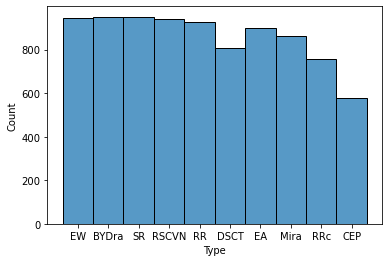

In [18]:
import seaborn as sns
sns.histplot(data=features_pd, x=features_pd.Type)